In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [65]:
df_read = pd.read_csv('./datasets/others/merge-date.csv', parse_dates=['date'])
df_read_per_zipcode = dict(tuple(df_read.groupby('PC4')))
# df_read_per_zipcode

In [66]:
df = df_read_per_zipcode[5611]

In [67]:
df_pm10 = df[['date','pm10']]
df_pm10

,date,pm10
0,2021-09-25 00:00:00,7.864949
1,2021-09-25 01:00:00,5.519824
2,2021-09-25 02:00:00,6.351879
3,2021-09-25 03:00:00,7.754018
4,2021-09-25 04:00:00,9.563934
...,...,...
1315,2021-11-18 19:00:00,27.236780
1316,2021-11-18 20:00:00,21.698681
1317,2021-11-18 21:00:00,23.983042
1318,2021-11-18 22:00:00,31.358852


In [68]:
# df_pm10['Lag_1'] = df_pm10['pm10'].shift(1)
# df_pm10['Lag_2'] = df_pm10['pm10'].shift(2)
# df_pm10['Lag_3'] = df_pm10['pm10'].shift(3)
# df_pm10['Lag_4'] = df_pm10['pm10'].shift(4)
# df_pm10 = df_pm10.reindex(columns=['pm10', 'Lag_1','Lag_2','Lag_3','Lag_4'])

# # Lag features
# X = pd.DataFrame({
#     'y_lag_2': df_pm10['pm10'].shift(1),
#     'y_lag_3': df_pm10['pm10'].shift(2),
#     'y_lag_4': df_pm10['pm10'].shift(3),
#     'y_lag_5': df_pm10['pm10'].shift(4),
# })

# # Multistep targets
# y = pd.DataFrame({
#     'y_step_3': df_pm10['pm10'].shift(-2),
#     'y_step_2': df_pm10['pm10'].shift(-1),
#     'y_step_1': df_pm10['pm10'],
# })

# data = pd.concat({'Targets': y, 'Features': X}, axis=1)

# data.head(10).style.set_properties(['Targets'], **{'background-color': 'darkgrey'}) \
#                    .set_properties(['Features'], **{'background-color': 'grey'})


In [69]:
def make_lags(df_pm10, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': df_pm10.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = df_pm10['pm10'].copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(df_pm10, steps):
    return pd.concat(
        {f'y_step_{i + 1}': df_pm10.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [70]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 6.28
Test RMSE: 8.55


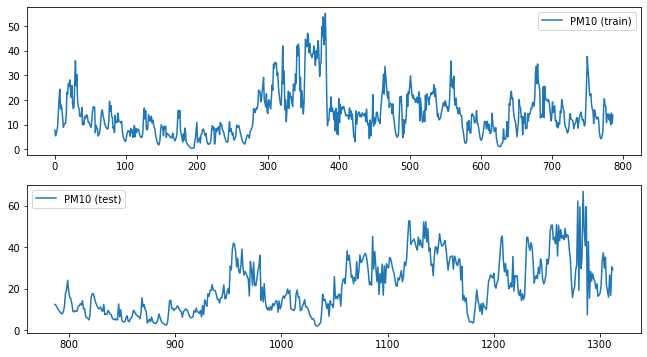

In [71]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

# RSME: Root Mean Square Error

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df_pm10.pm10[y_fit.index].plot(ax=ax1)
# ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM10 (train)', 'Forecast'])

ax2 = df_pm10.pm10[y_pred.index].plot(ax=ax2)
# ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM10 (test)', 'Forecast'])